# 2024 CITS4012 Project

_Make sure you change the file name with your group id._


# Readme

_If there is something to be noted for the marker, please mention here._

_If you are planning to implement a program with Object Oriented Programming style, please put those the bottom of this ipynb file_


# 1.Dataset Processing

(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)


### 1.1 Import Dependencies


In [39]:
import json, re, random, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
# from typing import Dict, List, Tuple
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

# from IPython.display import display, Javascript
# run the last cell in the notebook
# display(Javascript('Jupyter.notebook.execute_cells([-1])'))


import warnings
warnings.filterwarnings('ignore')

### 1.2 Set Seed for Reproducibility


In [40]:
CUDA = torch.cuda.is_available()

SEED = 42 
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED)
if CUDA: torch.cuda.manual_seed_all(SEED)

In [ ]:
TRAIN_PATH = 'data/train.json'
VAL_PATH = 'data/validation.json'
TEST_PATH = 'data/test.json'

In [ ]:
def load_nli_dataset(file_path):
    """
    Load NLI dataset from JSON file
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    examples = []
    for idx in range(len(data['premise'])):
        example = {
            'premise': data['premise'][str(idx)],
            'hypothesis': data['hypothesis'][str(idx)],
            'label': data['label'][str(idx)]
        }
        examples.append(example)
    return examples

def load_all_datasets():
    """Load all datasets (train, validation, test)"""
    train_data = load_nli_dataset(TRAIN_PATH)
    val_data = load_nli_dataset(VAL_PATH)
    test_data = load_nli_dataset(TEST_PATH)
    print(f">>> {len(train_data) + len(val_data) + len(test_data)} examples loaded:\n"
          f"    Training:   {len(train_data):,} examples\n"
          f"    Validation: {len(val_data):,} examples\n"
          f"    Test:       {len(test_data):,} examples")
    return train_data, val_data, test_data

train_data, val_data, test_data = load_all_datasets()

print(f"\nDataset Summary:")
print(f"Total examples: {len(train_data) + len(val_data) + len(test_data)}")
print(f"Training: {len(train_data)} examples")
print(f"Validation: {len(val_data)} examples") 
print(f"Test: {len(test_data)} examples")

>>> 26518 examples loaded:
    Training:   23,088 examples
    Validation: 1,304 examples
    Test:       2,126 examples

Dataset Summary:
Total examples: 26518
Training: 23088 examples
Validation: 1304 examples
Test: 2126 examples


### 1.3 Exploratory Data Analysis


In [ ]:
def analyze_dataset(data, dataset_name):
    """Analyze dataset characteristics"""
    
    print(f"\n=== {dataset_name.upper()} DATASET ANALYSIS ===")
    
    # Label distribution
    labels = [example['label'] for example in data]
    label_counts = Counter(labels)
    
    print(f"\nLabel Distribution:")
    for label, count in label_counts.items():
        percentage = (count / len(data)) * 100
        print(f"  {label}: {count} ({percentage:.2f}%)")
    
    # Text length analysis
    premise_lengths = [len(example['premise'].split()) for example in data]
    hypothesis_lengths = [len(example['hypothesis'].split()) for example in data]
    
    print(f"\nText Length Statistics:")
    print(f"  Premise length - Mean: {np.mean(premise_lengths):.2f}, "
          f"Median: {np.median(premise_lengths):.2f}, "
          f"Max: {max(premise_lengths)}")
    print(f"  Hypothesis length - Mean: {np.mean(hypothesis_lengths):.2f}, "
          f"Median: {np.median(hypothesis_lengths):.2f}, "
          f"Max: {max(hypothesis_lengths)}")
    
    print(f"\nSample Examples:")
    for i, example in enumerate(data[:2]):
        print(f"\n  Example {i+1}:")
        print(f"    Premise: {example['premise'][:100]}...")
        print(f"    Hypothesis: {example['hypothesis'][:100]}...")
        print(f"    Label: {example['label']}")
    
    return {
        'label_counts': label_counts,
        'premise_lengths': premise_lengths,
        'hypothesis_lengths': hypothesis_lengths
    }

# Analyze all datasets
train_stats = analyze_dataset(train_data, "Training")
val_stats = analyze_dataset(val_data, "Validation")
test_stats = analyze_dataset(test_data, "Test")



=== TRAINING DATASET ANALYSIS ===

Label Distribution:
  neutral: 14618 (63.31%)
  entails: 8470 (36.69%)

Text Length Statistics:
  Premise length - Mean: 18.08, Median: 16.00, Max: 10587
  Hypothesis length - Mean: 11.73, Median: 11.00, Max: 36

Sample Examples:

  Example 1:
    Premise: Pluto rotates once on its axis every 6.39 Earth days;...
    Hypothesis: Earth rotates on its axis once times in one day....
    Label: neutral

  Example 2:
    Premise: ---Glenn ========================================================= Once per day, the earth rotates a...
    Hypothesis: Earth rotates on its axis once times in one day....
    Label: entails

=== VALIDATION DATASET ANALYSIS ===

Label Distribution:
  neutral: 647 (49.62%)
  entails: 657 (50.38%)

Text Length Statistics:
  Premise length - Mean: 17.31, Median: 15.50, Max: 52
  Hypothesis length - Mean: 12.40, Median: 12.00, Max: 30

Sample Examples:

  Example 1:
    Premise: An introduction to atoms and elements, compounds, atomic

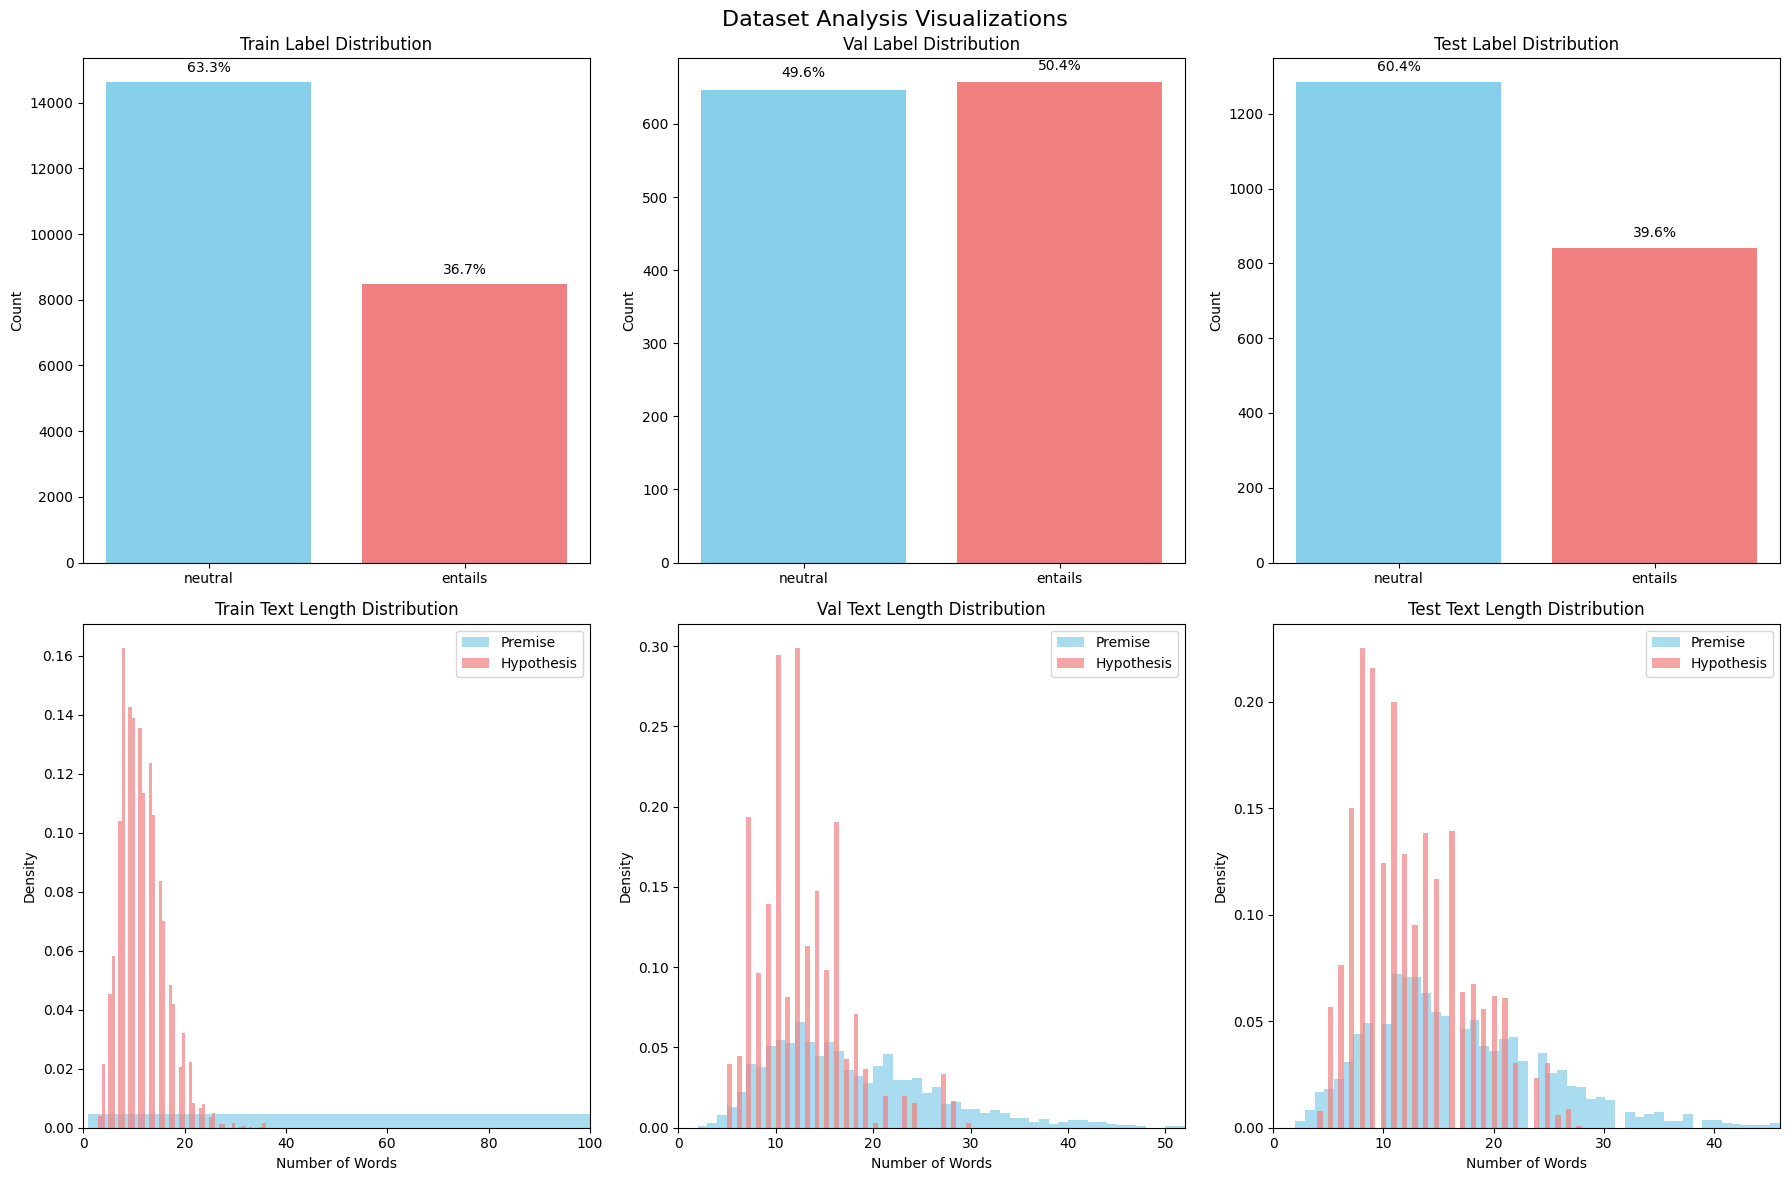

In [ ]:
def create_visualizations(train_stats, val_stats, test_stats):
    """Create visualizations for dataset analysis"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Dataset Analysis Visualizations', fontsize=16)
    datasets = ['Train', 'Val', 'Test']
    stats_list = [train_stats, val_stats, test_stats]
    
    for i, (dataset, stats) in enumerate(zip(datasets, stats_list)):
        labels = list(stats['label_counts'].keys())
        counts = list(stats['label_counts'].values())
        axes[0, i].bar(labels, counts, color=['skyblue', 'lightcoral'])
        axes[0, i].set_title(f'{dataset} Label Distribution')
        axes[0, i].set_ylabel('Count')
        total = sum(counts)
        for j, count in enumerate(counts):
            percentage = (count / total) * 100
            axes[0, i].text(j, count + total*0.01, f'{percentage:.1f}%', 
                           ha='center', va='bottom')
    
    for i, (dataset, stats) in enumerate(zip(datasets, stats_list)):
        axes[1, i].hist(stats['premise_lengths'], bins=50, alpha=0.7, 
                       label='Premise', color='skyblue', density=True)
        axes[1, i].hist(stats['hypothesis_lengths'], bins=50, alpha=0.7, 
                       label='Hypothesis', color='lightcoral', density=True)
        axes[1, i].set_title(f'{dataset} Text Length Distribution')
        axes[1, i].set_xlabel('Number of Words')
        axes[1, i].set_ylabel('Density')
        axes[1, i].legend()
        axes[1, i].set_xlim(0, min(100, max(stats['premise_lengths'] + stats['hypothesis_lengths'])))
    
    plt.tight_layout()
    plt.show()

# Create visualizations
create_visualizations(train_stats, val_stats, test_stats)


### 1.4 Preprocessing


In [ ]:
def clean_text(text: str) -> str:
    """
    Clean and preprocess text data
    """
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s.,!?;:\'"()-]', '', text)
    text = text.strip()
    return text

def preprocess_dataset(data, clean=True):
    """
    """
    processed_data = []
    for example in data:
        premise = example['premise']
        hypothesis = example['hypothesis']
        
        if clean:
            premise = clean_text(premise)
            hypothesis = clean_text(hypothesis)
        
        processed_example = {
            'premise': premise,
            'hypothesis': hypothesis,
            'label': example['label'],
            'premise_tokens': premise.split(),
            'hypothesis_tokens': hypothesis.split()
        }
        processed_data.append(processed_example)
    return processed_data

train_processed = preprocess_dataset(train_data)
val_processed = preprocess_dataset(val_data)
test_processed = preprocess_dataset(test_data)

print(f">>> Preprocessing complete")
print(f"Sample processed example:")
print(f"  Original premise: {train_data[0]['premise'][:100]}...")
print(f"  Cleaned premise: {train_processed[0]['premise'][:100]}...")
print(f"  Tokens: {train_processed[0]['premise_tokens'][:10]}...")

>>> Preprocessing complete
Sample processed example:
  Original premise: Pluto rotates once on its axis every 6.39 Earth days;...
  Cleaned premise: pluto rotates once on its axis every 6.39 earth days;...
  Tokens: ['pluto', 'rotates', 'once', 'on', 'its', 'axis', 'every', '6.39', 'earth', 'days;']...


In [7]:
def build_vocabulary(data):
    """
    Build vocabulary from dataset
    
    Args:
        data (List[Dict]): List of processed examples
        
    Returns:
        Dict[str, int]: Vocabulary mapping word to frequency
    """
    vocab = Counter()
    for example in data:
        vocab.update(example['premise_tokens'])
        vocab.update(example['hypothesis_tokens'])
    return dict(vocab)

def analyze_vocabulary(vocab, top_k):
    """
    Analyze vocabulary characteristics
    
    Args:
        vocab (Dict[str, int]): Vocabulary dictionary
        top_k (int): Number of top words to display
    """
    total_words = sum(vocab.values())
    unique_words = len(vocab)
    
    print(f"Vocabulary Analysis:")
    print(f"  Total word occurrences: {total_words:,}")
    print(f"  Unique words: {unique_words:,}")
    print(f"  Average frequency: {total_words/unique_words:.2f}")
    
    # Most frequent words
    most_frequent = Counter(vocab).most_common(top_k)
    print(f"\nTop {top_k} most frequent words:")
    for word, freq in most_frequent:
        percentage = (freq / total_words) * 100
        print(f"  '{word}': {freq} ({percentage:.2f}%)")
    
    # Word length analysis
    word_lengths = [len(word) for word in vocab.keys()]
    print(f"\nWord length statistics:")
    print(f"  Mean length: {np.mean(word_lengths):.2f}")
    print(f"  Median length: {np.median(word_lengths):.2f}")
    print(f"  Max length: {max(word_lengths)}")

print("Building vocabulary from training data...")
vocabulary = build_vocabulary(train_processed)
analyze_vocabulary(vocabulary, top_k=30)
vocab_size = len(vocabulary)
print(f"\nVocabulary size: {vocab_size:,}")


Building vocabulary from training data...
Vocabulary Analysis:
  Total word occurrences: 688,073
  Unique words: 35,863
  Average frequency: 19.19

Top 30 most frequent words:
  'the': 51949 (7.55%)
  'of': 29584 (4.30%)
  'a': 18494 (2.69%)
  'is': 18155 (2.64%)
  'and': 18008 (2.62%)
  'in': 14896 (2.16%)
  'to': 13257 (1.93%)
  'are': 8909 (1.29%)
  'that': 7398 (1.08%)
  'an': 4895 (0.71%)
  'as': 4709 (0.68%)
  'for': 4495 (0.65%)
  'by': 4425 (0.64%)
  'or': 4219 (0.61%)
  'from': 3710 (0.54%)
  'with': 3148 (0.46%)
  'on': 3141 (0.46%)
  'water': 2939 (0.43%)
  'be': 2817 (0.41%)
  'have': 2810 (0.41%)
  'it': 2756 (0.40%)
  'can': 2625 (0.38%)
  'energy': 2504 (0.36%)
  'most': 2267 (0.33%)
  'called': 2263 (0.33%)
  'which': 2176 (0.32%)
  'when': 2150 (0.31%)
  'one': 2137 (0.31%)
  'two': 2034 (0.30%)
  'at': 1835 (0.27%)

Word length statistics:
  Mean length: 8.25
  Median length: 8.00
  Max length: 82

Vocabulary size: 35,863


In [ ]:
print("Creating vocabulary...")
vocab = Vocabulary(vocabulary, min_freq=1)  # Filter out words with frequency < 2
print(f"Vocabulary size: {vocab.get_vocab_size()}")
print(f"Sample words: {list(vocab.word2idx.keys())[:10]}")


Creating vocabulary...
Vocabulary size: 35865
Sample words: ['<PAD>', '<UNK>', 'pluto', 'rotates', 'once', 'on', 'its', 'axis', 'every', '6.39']


In [8]:
print("="*60)
print("DATASET LOADING COMPLETE")
print("="*60)

print(f"\nDataset Overview:")
print(f"  Training examples: {len(train_processed):,}")
print(f"  Validation examples: {len(val_processed):,}")
print(f"  Test examples: {len(test_processed):,}")
print(f"  Total examples: {len(train_processed) + len(val_processed) + len(test_processed):,}")

print(f"\nData Characteristics:")
print(f"  Labels: {set([ex['label'] for ex in train_processed])}")
print(f"  Vocabulary size: {vocab_size:,}")
print(f"  Average premise length: {np.mean([len(ex['premise_tokens']) for ex in train_processed]):.1f} words")
print(f"  Average hypothesis length: {np.mean([len(ex['hypothesis_tokens']) for ex in train_processed]):.1f} words")

DATASET LOADING COMPLETE

Dataset Overview:
  Training examples: 23,088
  Validation examples: 1,304
  Test examples: 2,126
  Total examples: 26,518

Data Characteristics:
  Labels: {'entails', 'neutral'}
  Vocabulary size: 35,863
  Average premise length: 18.1 words
  Average hypothesis length: 11.7 words


# 2. Model Implementation

(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)


### 2.1 Model Instantiation

_For now we just make models with defualt hyperparameters_


In [36]:

def default_model_configs(vocab_size: int):
    """Central place for default hyperparameters across models."""
    return {
        "birnn": dict(
            vocab_size=vocab_size,
            embedding_dim=128,
            hidden_dim=128,
            num_layers=1,
            dropout=0.2,
            rnn_type='LSTM',
            padding_idx=0,
            num_classes=2,
        ),
        "attn": dict(  # NLIModelWithAttention
            vocab_size=vocab_size,
            embed_dim=100,
            hidden_size=128,
            embedding=None,
            dropout=0.3,
        ),
        "transformer": dict(
            vocab_size=vocab_size,
            embed_dim=128,
            nhead=4,
            hidden_dim=256,
            nlayers=2,
            dropout=0.2,
            num_classes=2,
        ),
    }

def make_model(name: str, vocab_size: int, device=None):
    """
    Build a model by name.
      name ∈ {'birnn', 'attn', 'transformer'}
    """
    device = device or (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
    cfgs = default_model_configs(vocab_size)

    name = name.lower()
    if name == "birnn":
        model = BiRNNModel(**cfgs["birnn"]).to(device)
    elif name == "attn":
        model = NLIModelWithAttention(**cfgs["attn"]).to(device)
    elif name == "transformer":
        model = TransformerNLI(**cfgs["transformer"]).to(device)
    else:
        raise ValueError(f"Unknown model name '{name}'. Use one of: birnn, attn, transformer.")
    return model

def count_params(model: nn.Module):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vocab_size = vocab.get_vocab_size() if hasattr(vocab, "get_vocab_size") else len(vocab)
models = {
    "birnn": make_model("birnn", vocab_size, device),
    "attn": make_model("attn", vocab_size, device),
    "transformer": make_model("transformer", vocab_size, device),
}

for name, m in models.items():
    total, trainable = count_params(m)
    print(f"{name.upper():12s} -> params: {total:,} (trainable: {trainable:,})  | device: {next(m.parameters()).device}")

BIRNN        -> params: 5,117,826 (trainable: 5,117,826)  | device: cpu
ATTN         -> params: 7,536,778 (trainable: 7,536,778)  | device: cpu
TRANSFORMER  -> params: 4,987,522 (trainable: 4,987,522)  | device: cpu


# Training Section

## Dataset/ Loaders

In [ ]:
# training function


===== Training BIRNN =====


Epoch 1/5 | Train Loss: 0.1035, Acc: 0.9596 | Val Loss: 1.0170, Acc: 0.7201


Epoch 2/5 | Train Loss: 0.0600, Acc: 0.9773 | Val Loss: 1.0989, Acc: 0.7032


Epoch 3/5 | Train Loss: 0.0408, Acc: 0.9853 | Val Loss: 1.2970, Acc: 0.7270


Epoch 4/5 | Train Loss: 0.0344, Acc: 0.9876 | Val Loss: 1.4610, Acc: 0.7071


Epoch 5/5 | Train Loss: 0.0258, Acc: 0.9899 | Val Loss: 1.7017, Acc: 0.7186
BIRNN Test Loss: 1.2962, Test Acc: 0.7394

===== Training ATTN =====


Epoch 1/5 | Train Loss: 0.2395, Acc: 0.9012 | Val Loss: 0.6133, Acc: 0.7347


Epoch 2/5 | Train Loss: 0.2131, Acc: 0.9126 | Val Loss: 0.6210, Acc: 0.7247


Epoch 3/5 | Train Loss: 0.1872, Acc: 0.9244 | Val Loss: 0.7239, Acc: 0.7032


Epoch 4/5 | Train Loss: 0.1672, Acc: 0.9340 | Val Loss: 0.7259, Acc: 0.7140


Epoch 5/5 | Train Loss: 0.1485, Acc: 0.9397 | Val Loss: 0.7454, Acc: 0.7178
ATTN Test Loss: 0.6675, Test Acc: 0.7192

===== Training TRANSFORMER =====


Epoch 1/5 | Train Loss: 0.5728, Acc: 0.6970 | Val Loss: 0.5705, Acc: 0.7055


Epoch 2/5 | Train Loss: 0.5096, Acc: 0.7470 | Val Loss: 0.6164, Acc: 0.6725


Epoch 3/5 | Train Loss: 0.4658, Acc: 0.7818 | Val Loss: 0.6206, Acc: 0.6794


Epoch 4/5 | Train Loss: 0.4393, Acc: 0.7981 | Val Loss: 0.6030, Acc: 0.6940


Epoch 5/5 | Train Loss: 0.4129, Acc: 0.8108 | Val Loss: 0.6274, Acc: 0.7032
TRANSFORMER Test Loss: 0.6237, Test Acc: 0.6472


In [ ]:
# tuning section

# 3.Testing and Evaluation

(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)


## Object Oriented Programming codes here

_You can use multiple code snippets. Just add more if needed_


In [10]:
class BiRNNModel(nn.Module):
    """Bidirectional RNN model for Natural Language Inference (simple, solid baseline).
       - Shared embedding + shared BiRNN encoder for premise/hypothesis
       - Representation = concat of last forward/backward hidden states (top layer)
       - Features = [p, h, |p-h|, p*h] -> small MLP -> logits
    """
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128,
                 num_layers=1, dropout=0.2, rnn_type='LSTM', padding_idx=0, num_classes=2):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn_type = rnn_type.upper()

        # Embedding
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)

        # BiRNN (dropout only applies between stacked layers; set to 0 if single layer)
        rnn_dropout = dropout if num_layers > 1 else 0.0
        if self.rnn_type == 'LSTM':
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                               batch_first=True, bidirectional=True, dropout=rnn_dropout)
        elif self.rnn_type == 'GRU':
            self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers,
                              batch_first=True, bidirectional=True, dropout=rnn_dropout)
        else:  # vanilla RNN (tanh)
            self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers,
                              batch_first=True, bidirectional=True, nonlinearity='tanh', dropout=rnn_dropout)

        self.dropout = nn.Dropout(dropout)

        # Classifier on [p, h, |p-h|, p*h] (each p/h is 2*hidden_dim)
        feat_dim = (hidden_dim * 2) * 4
        self.classifier = nn.Sequential(
            nn.Linear(feat_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, num_classes)  # 2 classes: entails / neutral
        )

    def _encode(self, x_ids, x_lengths):
        """
        Encode a sequence with BiRNN and return the last hidden state concat (fwd||bwd) from top layer.
        Args:
            x_ids:      (B, T) long
            x_lengths:  (B,)  long or int tensor with true lengths (>=1)
        Returns:
            rep: (B, 2H)
        """
        emb = self.embedding(x_ids)  # (B, T, E)
        # pack for efficient/padded-safe RNN
        x_lengths = torch.clamp(x_lengths, min=1).to(x_ids.device)
        packed = nn.utils.rnn.pack_padded_sequence(emb, x_lengths.cpu(), batch_first=True, enforce_sorted=False)
        if self.rnn_type == 'LSTM':
            _, (h_n, _) = self.rnn(packed)  # h_n: (num_layers*2, B, H)
        else:
            _, h_n = self.rnn(packed)       # h_n: (num_layers*2, B, H)

        # take top layer forward and backward states
        # layout in bidirectional: [layer0_fwd, layer0_bwd, ..., layerL-1_fwd, layerL-1_bwd]
        fwd_top = h_n[-2, :, :]  # (B, H)
        bwd_top = h_n[-1, :, :]  # (B, H)
        rep = torch.cat([fwd_top, bwd_top], dim=-1)  # (B, 2H)
        rep = self.dropout(rep)
        return rep

    def forward(self, premise, hypothesis, premise_lengths, hypothesis_lengths):
        """
        Args:
            premise:            (B, T) long
            hypothesis:         (B, T) long
            premise_lengths:    (B,)  long
            hypothesis_lengths: (B,)  long
        Returns:
            logits: (B, num_classes)
        """
        p = self._encode(premise, premise_lengths)      # (B, 2H)
        h = self._encode(hypothesis, hypothesis_lengths)# (B, 2H)

        feats = torch.cat([p, h, torch.abs(p - h), p * h], dim=-1)  # (B, 8H)
        logits = self.classifier(feats)  # (B, C)
        return logits
    


In [11]:

# ---------------------------
# Encoder
# ---------------------------
class EncoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, embedding=None, dropout=0.3):
        super().__init__()
        self.hidden_size = hidden_size
        if embedding is not None:
            self.embedding = embedding
        else:
            self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim, hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_len):
        # src: [batch, seq_len]
        embedded = self.dropout(self.embedding(src))  # [B, L, D]
        packed = nn.utils.rnn.pack_padded_sequence(embedded, src_len.cpu(), batch_first=True, enforce_sorted=False)
        outputs, hidden = self.gru(packed)  # hidden: [2, B, H]
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)  # [B, L, 2H]
        return outputs, hidden  # outputs = encoder states


# ---------------------------
# Attention (Luong)
# ---------------------------
class LuongAttention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attn = nn.Linear(hidden_size, hidden_size)

    def forward(self, decoder_hidden, encoder_outputs, mask=None):
        # decoder_hidden: [B, H]
        # encoder_outputs: [B, L, H]
        # Compute attention scores
        attn_scores = torch.bmm(encoder_outputs, decoder_hidden.unsqueeze(2)).squeeze(2)  # [B, L]
        if mask is not None:
            attn_scores.masked_fill_(~mask, -1e9)
        attn_weights = F.softmax(attn_scores, dim=1)  # [B, L]
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)  # [B, H]
        return context, attn_weights


# ---------------------------
# Decoder
# ---------------------------
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, embedding=None, dropout=0.3):
        super().__init__()
        self.hidden_size = hidden_size
        if embedding is not None:
            self.embedding = embedding
        else:
            self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        self.gru = nn.GRU(embed_dim + hidden_size, hidden_size, batch_first=True)
        self.attention = LuongAttention(hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, tgt, tgt_len, encoder_outputs, encoder_mask):
        # tgt: [B, L_t]
        embedded = self.dropout(self.embedding(tgt))  # [B, L_t, D]
        batch_size, L_t, _ = embedded.size()

        hidden = torch.zeros(1, batch_size, self.hidden_size, device=tgt.device)
        outputs = []

        for t in range(L_t):
            input_step = embedded[:, t, :]  # [B, D]
            context, attn_weights = self.attention(hidden.squeeze(0), encoder_outputs, encoder_mask)  # [B, H]
            rnn_input = torch.cat([input_step, context], dim=1).unsqueeze(1)  # [B, 1, D+H]
            output, hidden = self.gru(rnn_input, hidden)  # output: [B,1,H]
            outputs.append(output)

        outputs = torch.cat(outputs, dim=1)  # [B, L_t, H]
        return outputs  # decoder outputs


# ---------------------------
# Combined Model
# ---------------------------
class NLIModelWithAttention(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, hidden_size=128, embedding=None, dropout=0.3):
        super().__init__()
        self.encoder = EncoderRNN(vocab_size, embed_dim, hidden_size, embedding, dropout)
        self.decoder = DecoderRNN(vocab_size, embed_dim, hidden_size, embedding, dropout)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 2)  # 2 classes: entailment, neutral
        )

    def make_mask(self, seq, seq_len):
        mask = torch.arange(seq.size(1), device=seq.device).unsqueeze(0) < seq_len.unsqueeze(1)
        return mask  # [B, L]

    def forward(self, premise, hypothesis, premise_len, hypothesis_len):
        # Encode premise
        encoder_outputs, _ = self.encoder(premise, premise_len)  # [B, Lp, 2H]
        # Project to single direction size
        encoder_outputs = encoder_outputs[:, :, :self.encoder.hidden_size] + encoder_outputs[:, :, self.encoder.hidden_size:]
        encoder_mask = self.make_mask(premise, premise_len)

        # Decode hypothesis
        decoder_outputs = self.decoder(hypothesis, hypothesis_len, encoder_outputs, encoder_mask)  # [B, Lh, H]
        # Pooling
        premise_repr = torch.mean(encoder_outputs, dim=1)  # [B, H]
        hypothesis_repr = torch.mean(decoder_outputs, dim=1)  # [B, H]

        # Combine and classify
        combined = torch.cat([premise_repr, hypothesis_repr], dim=1)
        logits = self.classifier(combined)
        return logits
    



In [12]:
# ------------------------------
# Model 3: Transformer-based NLI
# ------------------------------

import math
import torch
import torch.nn as nn
import torch.nn.functional as F

# Positional Encoding (reuse your previous code)
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (B, T, E)
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# Transformer NLI Model
class TransformerNLI(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, nhead=4, hidden_dim=256, nlayers=2, dropout=0.2, num_classes=2):
        super().__init__()
        from torch.nn import TransformerEncoder, TransformerEncoderLayer

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_encoder = PositionalEncoding(embed_dim, dropout)

        encoder_layer = TransformerEncoderLayer(d_model=embed_dim, nhead=nhead,
                                                dim_feedforward=hidden_dim, dropout=dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=nlayers)
        self.dropout = nn.Dropout(dropout)

        # Classifier: [p, h, |p-h|, p*h]
        feat_dim = embed_dim * 4
        self.classifier = nn.Sequential(
            nn.Linear(feat_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )

    def _encode(self, x, lengths):
        # x: (B, T)
        emb = self.embedding(x) * math.sqrt(self.embedding.embedding_dim)
        emb = self.pos_encoder(emb)  # (B, T, E)
        emb = emb.transpose(0, 1)  # (T, B, E)
        mask = self._generate_pad_mask(x, lengths)  # (B, T)
        out = self.transformer_encoder(emb, src_key_padding_mask=mask)  # (T, B, E)
        out = out.transpose(0, 1)  # (B, T, E)
        # Mean pooling (ignore padded tokens)
        lengths = lengths.unsqueeze(1).to(out.device)
        pooled = torch.sum(out * (~mask.unsqueeze(-1)), dim=1) / lengths
        return self.dropout(pooled)

    def _generate_pad_mask(self, x, lengths):
        # True where padding, shape (B, T)
        B, T = x.size()
        mask = torch.arange(T, device=x.device).unsqueeze(0) >= lengths.unsqueeze(1)
        return mask

    def forward(self, premise, hypothesis, premise_lengths, hypothesis_lengths):
        p = self._encode(premise, premise_lengths)
        h = self._encode(hypothesis, hypothesis_lengths)
        feats = torch.cat([p, h, torch.abs(p - h), p * h], dim=-1)
        logits = self.classifier(feats)
        return logits



In [14]:
# Word-to-Index Mappings and Vocabulary Utilities

class Vocabulary:
    """Vocabulary class for word-to-index mappings"""
    
    def __init__(self, vocab_dict=None, min_freq=1):
        self.word2idx = {}
        self.idx2word = {}
        self.word_freq = {}
        
        # Special tokens
        self.PAD_TOKEN = '<PAD>'
        self.UNK_TOKEN = '<UNK>'
        
        # Add special tokens
        self.word2idx[self.PAD_TOKEN] = 0
        self.word2idx[self.UNK_TOKEN] = 1
        self.idx2word[0] = self.PAD_TOKEN
        self.idx2word[1] = self.UNK_TOKEN
        
        if vocab_dict is not None:
            self.build_vocab(vocab_dict, min_freq)
    
    def build_vocab(self, vocab_dict, min_freq=1):
        """Build vocabulary from word frequency dictionary"""
        idx = 2  # Start from 2 (0 and 1 are reserved for PAD and UNK)
        
        for word, freq in vocab_dict.items():
            if freq >= min_freq:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                self.word_freq[word] = freq
                idx += 1
    
    def encode(self, tokens):
        """Convert tokens to indices"""
        return [self.word2idx.get(token, self.word2idx[self.UNK_TOKEN]) for token in tokens]
    
    def decode(self, indices):
        """Convert indices to tokens"""
        return [self.idx2word.get(idx, self.UNK_TOKEN) for idx in indices]
    
    def __len__(self):
        return len(self.word2idx)
    
    def get_vocab_size(self):
        return len(self.word2idx)


In [ ]:

class NLIDataset(Dataset):
    """PyTorch Dataset for NLI data"""
    
    def __init__(self, data, vocab, max_length=128):
        self.data = data
        self.vocab = vocab
        self.max_length = max_length
        
        # Create label mapping
        self.label2idx = {'neutral': 0, 'entails': 1}
        self.idx2label = {0: 'neutral', 1: 'entails'}
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        example = self.data[idx]
        
        # Encode tokens
        premise_indices = self.vocab.encode(example['premise_tokens'])
        hypothesis_indices = self.vocab.encode(example['hypothesis_tokens'])
        
        # Truncate if too long
        premise_indices = premise_indices[:self.max_length]
        hypothesis_indices = hypothesis_indices[:self.max_length]
        
        # Ensure minimum length of 1 (add padding token if empty)
        if len(premise_indices) == 0:
            premise_indices = [0]  # PAD token
        if len(hypothesis_indices) == 0:
            hypothesis_indices = [0]  # PAD token
        
        # Get label
        label = self.label2idx[example['label']]
        
        return {
            'premise': torch.tensor(premise_indices, dtype=torch.long),
            'hypothesis': torch.tensor(hypothesis_indices, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long),
            'premise_length': len(premise_indices),
            'hypothesis_length': len(hypothesis_indices)
        }



In [46]:
from torch.utils.data import Dataset, DataLoader

label2idx = {"entails": 0, "neutral": 1}

# -----------------------------
# Dataset & Collate
# -----------------------------
class NLIDataset(torch.utils.data.Dataset):
    def __init__(self, data, vocab):
        self.data = data
        self.vocab = vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        premise_ids = torch.tensor(self.vocab.encode(item["premise_tokens"]), dtype=torch.long)
        hypothesis_ids = torch.tensor(self.vocab.encode(item["hypothesis_tokens"]), dtype=torch.long)
        label = torch.tensor(label2idx[item["label"]], dtype=torch.long)
        return premise_ids, hypothesis_ids, label

def collate_fn(batch):
    premises, hypotheses, labels = zip(*batch)
    premise_lengths = torch.tensor([len(p) for p in premises])
    hypothesis_lengths = torch.tensor([len(h) for h in hypotheses])
    
    padded_premise = nn.utils.rnn.pad_sequence(premises, batch_first=True, padding_value=0)
    padded_hypothesis = nn.utils.rnn.pad_sequence(hypotheses, batch_first=True, padding_value=0)
    labels = torch.stack(labels)
    return padded_premise, premise_lengths, padded_hypothesis, hypothesis_lengths, labels